In [1]:
import numpy as np
import faiss
import time
import torch
import pandas as pd
from os import path, makedirs
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from utils import load_embeddings

## CONFIG

In [3]:
model = 'mrl' # mrl, rr
arch = 'resnet50' # resnet18, resnet34, resnet50, resnet101, mobilenetv2
root = f'../../../inference_array/{arch}'
dataset = '1K' # 1K, 4K, V2, inat

In [4]:
index_type = 'ivf' # ivfpq, ivfsq, lsh, pq, ivf, opq

hnsw_max_neighbors = 32 # 8, 32

k = 2048 # shortlist length, default set to max supported by FAISS

nesting_list_dict = {
    'vgg19':  [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096],
    'resnet18': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
    'resnet34': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
    'resnet50': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048],
    'resnet101': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048],
    'mobilenetv2': [10, 20, 40, 80, 160, 320, 640, 1280],
    'convnext_tiny': [12, 24, 48, 96, 192, 384, 768]
}

nesting_list = nesting_list_dict[arch]

ivf_configs = {
    'C1': {'nlist': 2048},
    'C2': {'nlist': 512},
    'C3': {'nlist': 128},
    'C4': {'nlist': 4096},
    'C5': {'nlist': 8192},
    'C6': {'nlist': 256},
    'C7': {'nlist': 1024}
}

config_id = 'C7'
    
# nbits = ivfpq_configs[config_id]['nbits'] # nbits used to represent centroid id; total possible is k* = 2**nbits

nlist = ivf_configs[config_id]['nlist']  # how many Voronoi cells (must be >= k*)

In [5]:
if index_type == 'exactl2':
    use_gpu = 1 # GPU inference for exact search
else:
    use_gpu = 0

if use_gpu and faiss.get_num_gpus() == 0:
    raise Exception("GPU search is enabled but no GPU was found.")

## Plots

In [7]:
import seaborn as sns

In [8]:
plt.style.use('seaborn-whitegrid')
sns.set_context('talk')
sns.set_style("white")

In [9]:
def get_invlists(index): 
    index = faiss.read_index(index)
    invlists = index.invlists
    all_ids = []
    bins = []
    for listno in range(index.nlist): 
        ls = invlists.list_size(listno)
        if ls == 0: continue
        ids = faiss.rev_swig_ptr(invlists.get_ids(listno), ls).copy()
        all_ids.append(ids)
        bins.append(len(ids))
    del index
    return all_ids, bins

In [10]:
index_files = {}

In [16]:
TVDs = {
8: 0.0007830626151,
16: 0.0002710860909,
32: 0.0001552219862,
64:  0.0003651896396,
128: 0.0006069480588,
256: 0.0006804511841,
512: 0.0007603661853,
1024: 0.0007473010084,
2048: 0.0005379413265
}

TVD_2048 = {
8:0.001283394139,
16:0.001213469176,
32:0.0009486557904,
64:0.0007768816719,
128:0.0006945503814,
256:0.0006419974382,
512:0.000649082282,
1024:0.000586784595,
2048:0.0005379413265
}

../../../inference_array/resnet50/index_files/ff8/1K_ivf_8m_nbits8_nlist2048_d8.index
../../../inference_array/resnet50/index_files/mrl-ivf/8/1K_ivf_nlist2048_d8.index
../../../inference_array/resnet50/index_files/ff16/1K_ivf_16m_nbits8_nlist2048_d16.index
../../../inference_array/resnet50/index_files/mrl-ivf/16/1K_ivf_nlist2048_d16.index
../../../inference_array/resnet50/index_files/ff32/1K_ivf_32m_nbits8_nlist2048_d32.index
../../../inference_array/resnet50/index_files/mrl-ivf/32/1K_ivf_nlist2048_d32.index
../../../inference_array/resnet50/index_files/ff64/1K_ivf_64m_nbits8_nlist2048_d64.index
../../../inference_array/resnet50/index_files/mrl-ivf/64/1K_ivf_nlist2048_d64.index
../../../inference_array/resnet50/index_files/ff128/1K_ivf_128m_nbits8_nlist2048_d128.index
../../../inference_array/resnet50/index_files/mrl-ivf/128/1K_ivf_nlist2048_d128.index
../../../inference_array/resnet50/index_files/ff256/1K_ivf_256m_nbits8_nlist2048_d256.index
../../../inference_array/resnet50/index_fil

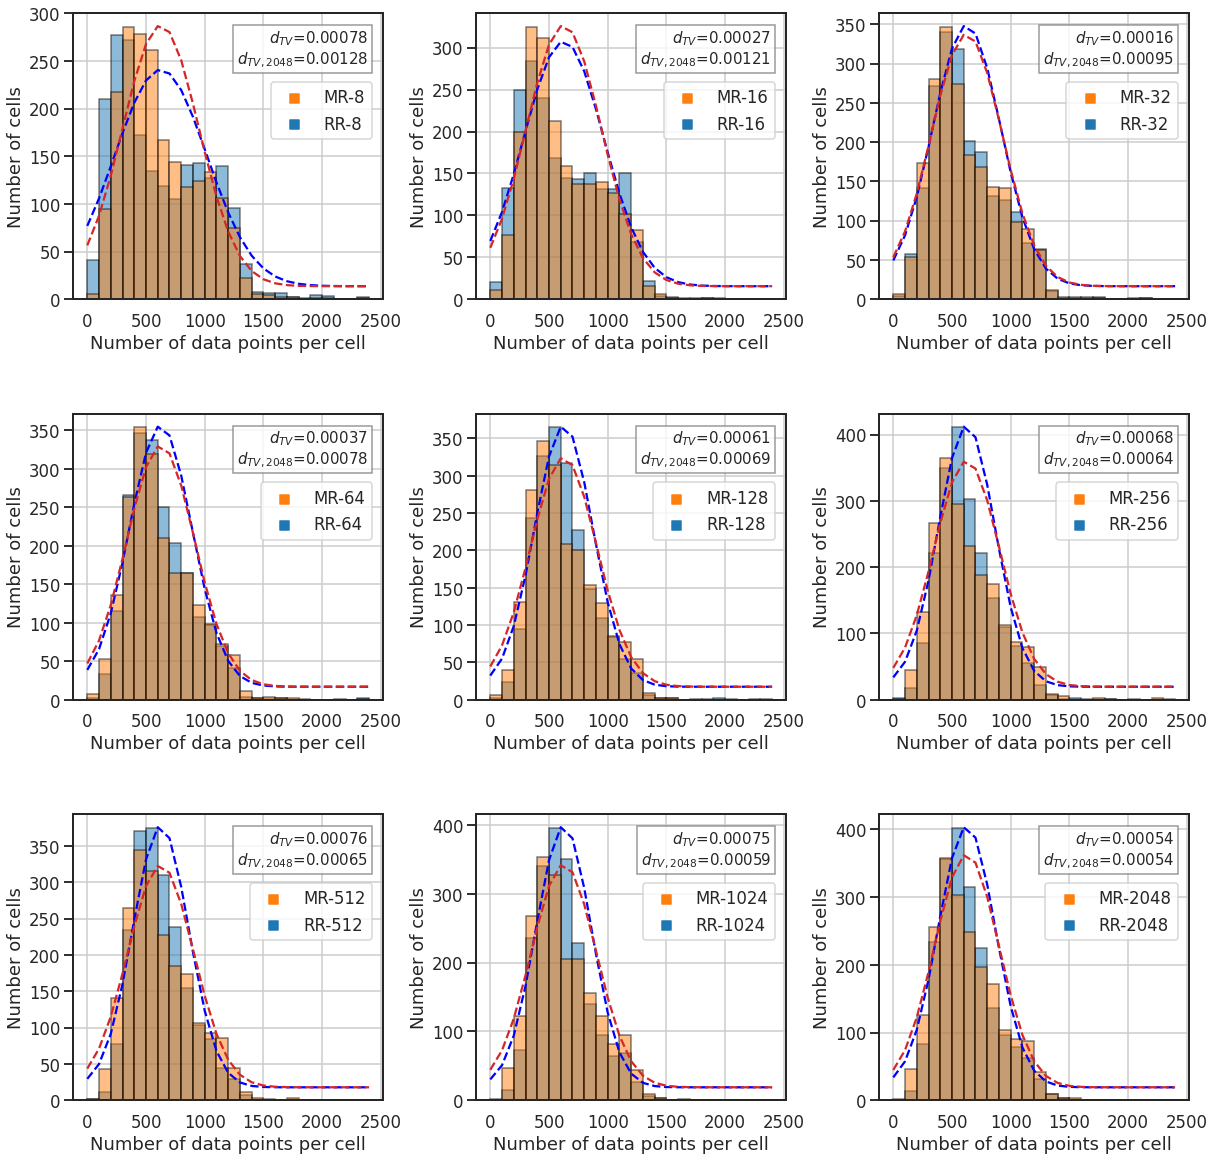

In [21]:
# All plots together
config = 'ivf'
dims = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]
plt.figure(figsize=(20, 20))
bins_dict = {}
probs = {}
for i, dim in enumerate(dims):
    
    model_rr = f'rr{dim}/'
    if dim == 2048:
        index_file = root+'index_files/rr-ivf/2048/1K_ivf_nlist2048_d2048.index'
    else:
        index_file = root+'index_files/'+model_rr+f"1K_ivf_{dim}m_nbits8_nlist2048_d{dim}.index" 
        
    print(index_file)
    if not model_rr in index_files.keys():
        all_ids, counts_per_cell_rr = get_invlists(index_file)
        index_files[model_rr] = (all_ids, counts_per_cell_rr)
    else:
        all_ids, counts_per_cell_rr = index_files[model_rr]
    
    df_1 = pd.DataFrame(counts_per_cell_rr)
    
    model_mrl = f'mrl-{config}/{dim}/'
    index_file = root+'index_files/'+model_mrl+f"1K_ivf_nlist2048_d{dim}.index"
    print(index_file)
    
    if not model_mrl in index_files.keys():
        all_ids, counts_per_cell_mrl = get_invlists(index_file)
        index_files[model_mrl] = (all_ids, counts_per_cell_mrl)
    else:
        all_ids, counts_per_cell_mrl = index_files[model_mrl]
        
    df_2 = pd.DataFrame(counts_per_cell_mrl)

    ax = plt.subplot(3, 3, i + 1)
    n, bins_1, patches = plt.hist(counts_per_cell_rr, edgecolor = "black", label=model_rr.replace("/"," "), alpha=0.5, bins=[i for i in range(0, 2500, 100)], color='tab:blue')
    n, bins_2, patches = plt.hist(counts_per_cell_mrl, edgecolor = "black", label=model_mrl.replace("/"," "), alpha=0.5, bins=[i for i in range(0, 2500, 100)], color='tab:orange')
    
    bins_dict[dim] = [bins_1, bins_2]

    mu_1, sigma_1 = df_1.describe()[0][1], df_1.describe()[0][2]
    mu_2, sigma_2 = df_2.describe()[0][1], df_2.describe()[0][2]
    
    y_1 = ((1 / (np.sqrt(2 * np.pi) * sigma_1)) * np.exp(-0.5 * (1 / sigma_1 * (bins_1 - mu_1))**2))
    y_2 = ((1 / (np.sqrt(2 * np.pi) * sigma_2)) * np.exp(-0.5 * (1 / sigma_2 * (bins_2 - mu_2))**2))
    probs[dim] = [y_1, y_2]
    
    ax2 = ax.twinx()
    ax2.plot(bins_1, y_1, '--', color ='blue')
    ax2.plot(bins_2, y_2, '--', color ='tab:red')
    ax2.get_yaxis().set_visible(False)

    plt.scatter([], [], marker='s', label=f'MR-{dim}', c='tab:orange')
    plt.scatter([], [], marker='s', label=f'RR-{dim}', c='tab:blue')

    ax.annotate('$d_{TV}$='+f'{round(TVDs[dim],5)}' + "\n" + '$d_{TV,2048}$='+f'{round(TVD_2048[dim],5)}', xy=(1, 1), xytext=(-15, -15), fontsize=15, xycoords='axes fraction', textcoords='offset pixels', bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'), horizontalalignment='right', verticalalignment='top')
    
    ax.set_xlabel('Number of data points per cell')
    ax.set_ylabel('Number of cells')
    mrl_title = model_mrl.replace("/"," ").replace("-ivf",'').upper()

    plt.legend(loc='lower right',frameon=True, bbox_to_anchor=(0.99, 0.53))
    ax.grid()
    
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.savefig("IVF_Cell_dist.pdf", bbox_inches="tight")